In [1]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Let's see if we can use PCA to distinguish the chemistry specific cells based on differences in their input features

In [32]:
import os
import pandas as pd

def summarize_features(input_df, chemistry, chemistry_filepath, desired_features):
    tdf = input_df[desired_features]  # ✅ fixed: 'tdf' was undefined

    agg_data = {}
    for col in tdf.columns:
        agg_data[f"{col}_mean"] = tdf[col].mean()
        agg_data[f"{col}_std"] = tdf[col].std()
        agg_data[f"{col}_min"] = tdf[col].min()
        agg_data[f"{col}_max"] = tdf[col].max()
    
    # Add metadata
    agg_data["chemistry"] = chemistry
    agg_data["file"] = chemistry_filepath
    return agg_data


def agg_chem_features(input_dir): 
    chemistries = os.listdir(input_dir)
    desired_features = ["cycle_index","normalized_time","voltage_v", "c_rate","temperature_k"]
    all_data = []
    for chemistry in chemistries:
        chemistry_path = os.path.join(input_dir, chemistry)
        for chemistry_folder in os.listdir(chemistry_path):
            chemistry_filepath = os.path.join(chemistry_path, chemistry_folder)
            chemistry_filepath_dir = os.listdir(chemistry_filepath)
            desired_files = [temp_file for temp_file in chemistry_filepath_dir if "error_log" not in temp_file]
            
            charge_filepath = None
            discharge_filepath = None  # ✅ ensure defined before loop

            for file in desired_files: 
                if "discharge" in file:  # ✅ fixed: check 'file', not 'desired_files'
                    discharge_filepath = os.path.join(chemistry_filepath, file)  # ✅ fixed: wrong join
                elif "charge" in file: 
                    charge_filepath = os.path.join(chemistry_filepath, file)  # ✅ fixed: wrong join
                    
            # ✅ only proceed if both files were found
            if not (charge_filepath and discharge_filepath):
                continue
                
            charge_df = pd.read_csv(charge_filepath)
            discharge_df = pd.read_csv(discharge_filepath)
            if len(charge_df) > 0 and len(discharge_df)>0: 
                if charge_df.c_rate.iloc[0] == "variable" or discharge_df.c_rate.iloc[0] == "variable": 
                    continue 
                else: 
                    charge_data = summarize_features(charge_df, chemistry, charge_filepath, desired_features)
                    discharge_data = summarize_features(discharge_df, chemistry, discharge_filepath, desired_features)

                    # ✅ convert dicts to DataFrames for concat
                    charge_data = pd.DataFrame([charge_data])
                    discharge_data = pd.DataFrame([discharge_data])

                    # ✅ fixed prefixing logic
                    charge_data.columns = ['charge_' + col if col not in ['chemistry', 'file'] else col for col in charge_data.columns]
                    discharge_data.columns = ['discharge_' + col if col not in ['chemistry', 'file'] else col for col in discharge_data.columns]

                    combined_df = pd.concat([charge_data, discharge_data], axis=1)  # ✅ axis=1 to combine horizontally
                    all_data.append(combined_df)
    
    # Combine all per-file aggregates
    result_df = pd.concat(all_data, ignore_index=True)  # ✅ concat instead of DataFrame(list_of_dfs)
    return result_df


input_dir = r'D:\Capstone\Battery_Classifier\assets\processed'
result_df = agg_chem_features(input_dir)


In [39]:
#remove unneeded features: 
strip_cols = ['charge_cycle_index_min', 'charge_cycle_index_max', 'charge_cycle_index_mean', 'charge_cycle_index_std',
              'charge_normalized_time_min', 'charge_normalized_time_max', 'discharge_c_rate_min', 'discharge_c_rate_max',
              'discharge_c_rate_std', 'charge_c_rate_min', 'charge_c_rate_max', 'charge_c_rate_std', 
              'discharge_temperature_k_max', 'discharge_temperature_k_min', 'discharge_temperature_k_std',
              'charge_temperature_k_max', 'charge_temperature_k_min', 'charge_temperature_k_std', 
              'discharge_temperature_k_mean', 'file', 'discharge_cycle_index_mean', 'discharge_cycle_index_max',
              'discharge_cycle_index_min', 'discharge_cycle_index_std',
              'discharge_normalized_time_max', 'discharge_normalized_time_min', 'discharge_normalized_time_std']

strip_df = result_df.drop(columns=strip_cols, errors='ignore')
strip_df = strip_df.iloc[:, :-1]
strip_df

,charge_normalized_time_mean,charge_normalized_time_std,charge_voltage_v_mean,charge_voltage_v_std,charge_voltage_v_min,charge_voltage_v_max,charge_c_rate_mean,charge_temperature_k_mean,chemistry,discharge_normalized_time_mean,discharge_voltage_v_mean,discharge_voltage_v_std,discharge_voltage_v_min,discharge_voltage_v_max,discharge_c_rate_mean
0,0.5,0.291689,4.041235,0.188019,3.176806,4.200711,0.500,298.00,LCO,0.5,3.732657,0.207325,2.749605,4.145538,0.500
1,0.5,0.291674,4.082167,0.170051,3.217925,4.200728,0.500,323.00,LCO,0.5,3.685704,0.225226,2.749605,4.136139,0.500
2,0.5,0.291591,4.005218,0.105416,3.609444,4.193748,0.500,298.00,LCO,0.5,3.687026,0.220713,2.699537,4.097848,0.500
3,0.5,0.291591,4.034677,0.092454,3.686996,4.193388,0.500,298.00,LCO,0.5,3.640069,0.215495,2.699628,4.082493,0.500
4,0.5,0.291591,3.970293,0.117686,3.543206,4.193987,1.000,298.00,LCO,0.5,3.624121,0.200375,2.699296,4.027569,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,0.5,0.293045,4.168109,0.065905,3.929422,4.200124,0.050,278.15,NMC,0.5,3.654494,0.340073,2.499986,4.160957,0.050
470,0.5,0.292308,4.135764,0.132579,3.687257,4.200143,1.025,298.15,NMC,0.5,3.403410,0.411287,2.499984,4.170721,1.025
471,0.5,0.293045,4.055626,0.174268,3.655836,4.200072,0.050,308.15,NMC,0.5,3.652262,0.349480,2.499989,4.167115,0.050
472,0.5,0.293045,3.731584,0.213670,2.998000,4.139980,0.050,298.00,NMC,0.5,3.680956,0.258448,2.518000,4.175000,0.050


Number of PCA components needed for 95% variance: 6


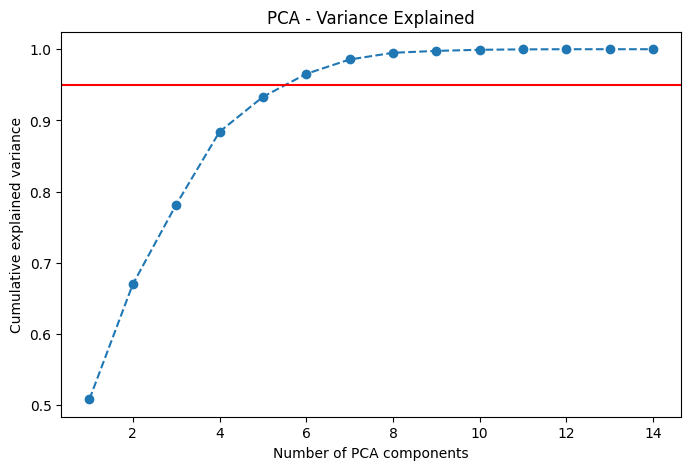

In [43]:
#Now train PCA model:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

X = strip_df[[col for col in strip_df.columns if col != 'chemistry']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca.fit(X_scaled)

# Step 4: Calculate cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Step 5: Find number of components needed for 95% variance
n_components_95 = (cumulative_variance < 0.95).sum() + 1
print(f"Number of PCA components needed for 95% variance: {n_components_95}")

# Step 6: Optional - plot cumulative variance
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA - Variance Explained")
plt.show()

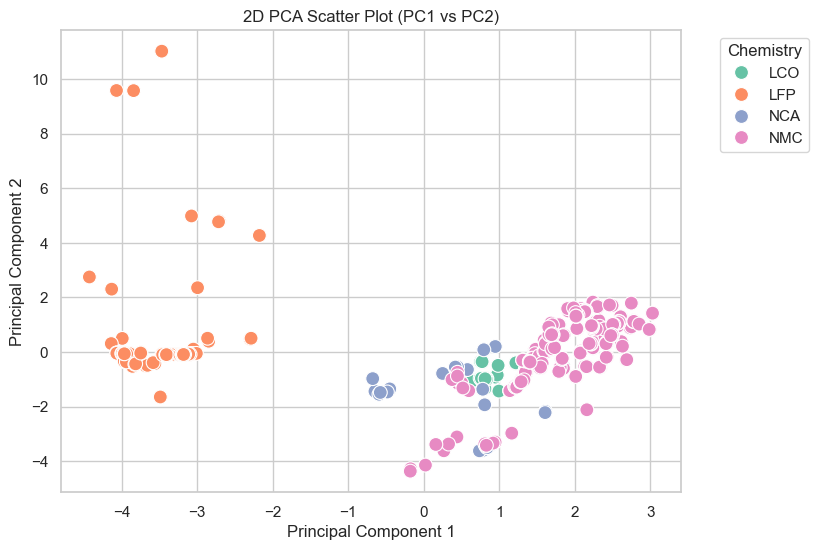

In [51]:
#Let's see how well a 2D projection would help separate the groups: 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# --- Step 0: Prepare numeric features (exclude chemistry) ---
X = strip_df[[col for col in strip_df.columns if col != 'chemistry']]

# --- Step 1: Standardize ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 2: PCA to 2 components ---
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

# --- Step 3: Optional KMeans clustering ---
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# --- Step 4: Create DataFrame for plotting ---
plot_df = pd.DataFrame({
    'PC1': X_pca_2[:,0],
    'PC2': X_pca_2[:,1],
    'chemistry': strip_df['chemistry'],
    'cluster': clusters
})


plt.figure(figsize=(8,6))
sns.scatterplot(
    data=plot_df,
    x='PC1',
    y='PC2',
    hue='chemistry',    # color by chemistry
    palette='Set2',
    s=100
)
plt.title("2D PCA Scatter Plot (PC1 vs PC2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Chemistry', bbox_to_anchor=(1.05, 1), loc=2)
plt.show()


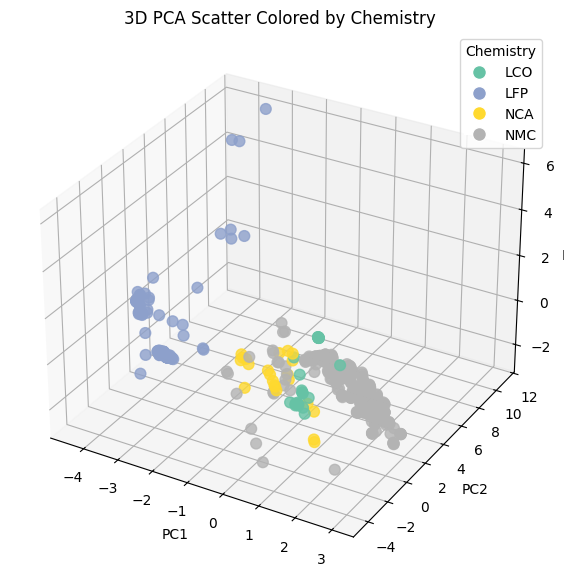

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

# --- Step 0: Prepare numeric features (exclude chemistry) ---
X = strip_df[[col for col in strip_df.columns if col != 'chemistry']]

# --- Step 1: Standardize ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 2: PCA to 3 components ---
pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(X_scaled)

# --- Step 3: KMeans clustering (optional, 3 clusters) ---
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# --- Step 4: Prepare chemistry codes and labels ---
chem_codes = strip_df['chemistry'].astype('category').cat.codes
chem_labels = strip_df['chemistry'].astype('category').cat.categories

# --- Step 5: 3D scatter plot colored by chemistry ---
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca_3[:,0], 
    X_pca_3[:,1], 
    X_pca_3[:,2], 
    c=chem_codes, 
    cmap='Set2', 
    s=60, 
    alpha=0.8
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Scatter Colored by Chemistry')

# Correct legend that matches scatter colors
scatter_colors = scatter.cmap(scatter.norm(range(len(chem_labels))))
handles = [Line2D([0],[0], marker='o', color='w', 
                  markerfacecolor=scatter_colors[i], 
                  markersize=10)
           for i in range(len(chem_labels))]
ax.legend(handles, chem_labels, title='Chemistry')

plt.show()

